# Zero Quadratic Model

In [1]:
import numpy as np
import random

from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import BosonSite, FermionSite
from tenpy.models.lattice import Square

class ZeroQuadraticModel(CouplingMPOModel):

    def __init__(self, params):
        CouplingMPOModel.__init__(self, params)

    @staticmethod
    def stats(params):
        return params.get('mod', 'Bos') #placeholder 'Bos'

    def init_sites(self, params):
        conserve = params.get('conserve', 'N')
        if "Bos" in self.stats(params):
            Nmax = params.get('Nmax', 1)
            site = BosonSite(Nmax=Nmax, conserve=conserve)  # conserve=conserve
        else:
            site = FermionSite(conserve=conserve)
        return site

    def init_lattice(self, params):
        if "Bos" in self.stats(params):
            L_default = (4, 4)
        else:
            L_default = (3, 6)
        L = params.get('L', L_default)
        #L = (params.get('Lx', 4), params.get('Ly',4))
        order = params.get('order', 'Cstyle')
        bc_MPS = params.get('bc_MPS', 'infinite')
        bc_x = params.get('bc_x', 'periodic')
        bc_y = params.get('bc_y', 'periodic')
        bc = [bc_x, bc_y]
        site = self.init_sites(params)
        lat = Square(L[0], L[1], site, order=order, bc_MPS=bc_MPS, bc=bc)
        return lat

    def init_terms(self, params):
        if "Bos" in self.stats(params):
            creation, annihilation = 'Bd', 'B'
            nphi_default = (1, 4)
            L_default = (4, 4)
            V_default = 0
        else:
            creation, annihilation = 'Cd', 'C'
            nphi_default = (1, 3)
            L_default = (6, 6)
            V_default = 10
        t = params.get('t', 1)
        t3 = params.get('t3', 0) #Change this for t_3
        nphi = params.get('nphi', nphi_default)
        nphi_2pi = 2 * np.pi * nphi[0] / nphi[1]
        phi_2pi = 2 * np.pi * params.get('phi', 0.0)
        L = params.get('L', L_default)
        _Lx, _Ly = L[0], L[1]
        V = params.get('V', V_default)
        mu = params.get('mu', 0)

        # --- x-hopping 
        dx = np.array([1, 0])
        # print(lat.coupling_shape(dx))
        tx_phi = -t*np.ones((_Lx, _Ly), dtype=complex)
        tx3_phi = -t3*np.ones((_Lx, _Ly), dtype=complex)
        # print("tx_phi = ", tx_phi)
        self.add_coupling(-t, 0, creation, 0, annihilation, dx)
        self.add_coupling(np.conj(-t), 0, creation, 0, annihilation, -dx)  # H.c.
        self.add_coupling(-t3, 0, creation, 0, annihilation, 2*dx)
        self.add_coupling(np.conj(-t3), 0, creation, 0, annihilation, -2*dx)

        # --- y-hopping (Landau-x gauge)
        dy = np.array([0, 1])
        # print(lat.coupling_shape(dy))
        ty_phi = -t*np.ones((_Lx, _Ly), dtype=complex)
        ty_phi = self.coupling_strength_add_ext_flux(ty_phi, dy, [0, phi_2pi])
        ty3_phi = -t3*np.ones((_Lx, _Ly), dtype=complex)
        ty3_phi = self.coupling_strength_add_ext_flux(ty3_phi, 2*dy, [0, phi_2pi])
        for ix in range(_Lx):
            ty_phi[ix, :] *= np.exp(1j * ix * nphi_2pi)
            ty3_phi[ix, :] *= np.exp(1j*ix*nphi_2pi*2)
        self.add_coupling(ty_phi, 0, creation, 0, annihilation, dy)
        self.add_coupling(np.conj(ty_phi), 0, creation, 0, annihilation, -dy)  # H.c.
        self.add_coupling(ty3_phi, 0, creation, 0, annihilation, 2*dy)
        self.add_coupling(np.conj(ty3_phi), 0, creation, 0, annihilation, -2*dy)
        
        self.add_coupling(V, 0, 'N', 0, 'N', dx)
        self.add_coupling(V, 0, 'N', 0, 'N', dy)
        
        # --- chemical potential
        #self.add_onsite(-mu, 0, 'N') #(No onsite potential)

# Bosonic

In [3]:
import numpy as np
import random

from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import BosonSite, FermionSite
from tenpy.models.lattice import Square

import logging
logging.basicConfig(level=logging.INFO)

data1 = dict(phi_ext=np.linspace(0, 2.0, 21), QL=[], ent_spectrum=[], mr_ent_spectrum=[])


model_params = dict(Lx=4, Ly=4, filling=(1, 8), nphi=(1, 4), mod = 'BosHof',
                    Jx=1, Jy=1, mu=0, U=0, Nmax=1,
                    bc_MPS='infinite', bc_x='periodic', bc_y='periodic',
                    conserve=None, order='default', gauge='landau_x')

dmrg_params = {
    'mixer': True,  # setting this to True helps to escape local minima
    'mixer_params': {
        'amplitude': 1.e-5,
        'decay': 1.2,
        'disable_after': 30
    },
    'trunc_params': {
        'chi_max': 50,
        'svd_min': 1.e-10,
    },
    'max_E_err': 1.e-8,
    'max_S_err': 1.e-6,
    'max_sweeps': 150,
    'verbose': 1,
    'combine': True
}

L = model_params['Lx'] * model_params['Ly']
fill = model_params['filling'][0] / model_params['filling'][1]
prod_state = np.zeros(L, dtype=int)
prod_state[random.sample(range(L), int(fill*L))] = 1
print(prod_state)

eng = None
QLs = []
for phi in np.linspace(0, 2.0, 21):

    model_params['phi'] = phi
    M = ZeroQuadraticModel(model_params)
    M.init_lattice(model_params)
    #tells you bond dimension of MPO:
    print('bond_dim: {}'.format(max(M.H_MPO.chi)))
    if eng is None:  # first time in the loop
        psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    else:
        dmrg_params['mixer'] = False
        eng.init_env(model=M)  # re-initialize
    E, psi = eng.run()
    QL = psi.average_charge(bond=0)[0]
    data1['QL'].append(QL)
    data1['ent_spectrum'].append(psi.entanglement_spectrum(by_charge=True)[0])

    
    

psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
E, psi = eng.run()

(Un, W, q, ov, trunc_err) = psi.compute_K(perm=M.lat, trunc_par={'chi_max': 400}, canonicalize=1.e-6, verbose=0)

for i in range(len(W)):
    qval=q.to_qflat()[i][0] 
    K=np.angle(W[i])/np.pi 
    epsilon=-np.log(np.abs(W[i]))
    data1['mr_ent_spectrum'].append([K, epsilon, qval])

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQuadraticModel
Reading 'bc_MPS'='infinite' for config ZeroQuadraticModel
Reading 'bc_x'='periodic' for config ZeroQuadraticModel
Reading 'bc_y'='periodic' for config ZeroQuadraticModel
Reading 'conserve'=None for config ZeroQuadraticModel
Reading 'Nmax'=1 for config ZeroQuadraticModel
Reading 'nphi'=(1, 4) for config ZeroQuadraticModel
Reading 'phi'=0.0 for config ZeroQuadraticModel
Reading 'mu'=0 for config ZeroQuadraticModel
bond_dim: 10
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Updating environment
.
Reading 'max_sweeps'=150 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff


Updating environment
.....
sweep 10, age = 528
Energy = -0.8383807056423613, S = nan, norm_err = 8.0e-07
Current memory usage 230720.0 MB, time elapsed: 94.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0093e-05, max_E_trunc = 2.6409e-04
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 1008
Energy = -0.8383812841560676, S = nan, norm_err = 1.3e-07
Current memory usage 230720.0 MB, time elapsed: 138.6 s
Delta E = -5.7851e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9429e-05, max_E_trunc = 2.6161e-04
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 1488
Energy = -0.8383812744328054, S = 1.2282345329482380, norm_err = 1.9e-12
Current memory usage 230720.0 MB, time elapsed: 165.5 s
Delta E = 9.7233e-10, Delta S = nan (per sweep)
max_trunc_err =

IndexError: index 0 is out of bounds for axis 0 with size 0

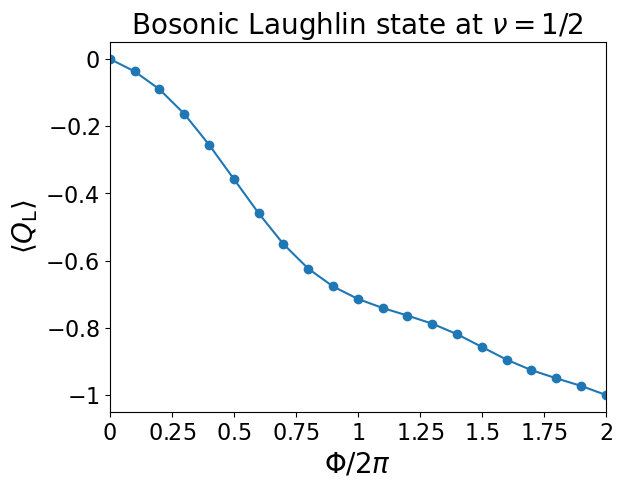

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data1['phi_ext'], data1['QL']-data1['QL'][0], marker='o')
ax.set_xlabel(r"$\Phi / 2 \pi$", fontsize=20)
ax.set_ylabel(r"$ \langle Q_\mathrm{L} \rangle $", fontsize=20)
ax.set_title(r"Bosonic Laughlin state at $\nu=1/2$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([0, 2])
#plt.savefig('Bosonic_nu=1_2_charge_pumping.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_by_charge = {}
for phi_ext, spectrum in zip(data1['phi_ext'], data1['ent_spectrum']):
    for q, s in spectrum:
        if q > -4:
            q = q[0]
            label = ""
            if q not in color_by_charge:
                label = "q={q:d}".format(q=q)
                color_by_charge[q] = colors[len(color_by_charge) % len(colors)]
            color = color_by_charge[q]
            ax.plot(phi_ext*np.ones(s.shape), s,
                    linestyle='', marker='x', color=color, label=label)
ax.set_xlabel(r"$\Phi / 2 \pi$", fontsize=20)
ax.set_ylabel(r"$ \epsilon_\alpha $", fontsize=20)
ax.set_ylim(0., 8.)
ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([0, 2])
plt.savefig('Bosonic_nu=1/2_ent_spectrum')
plt.show()

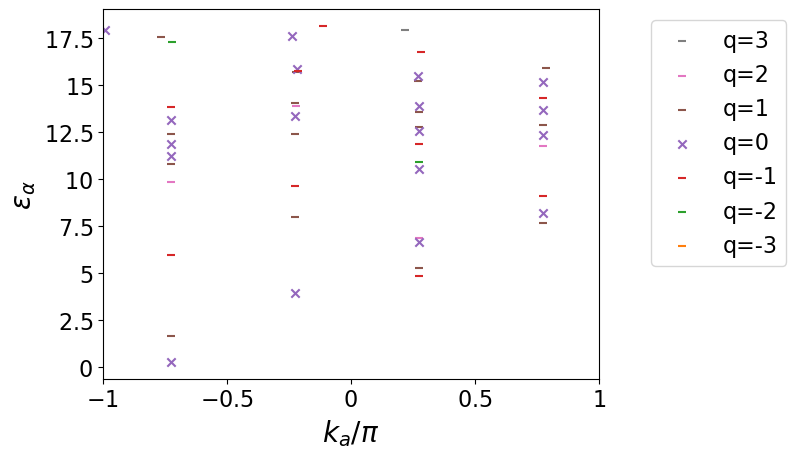

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
    
x = []
y = []
z = []    

for row in data1['mr_ent_spectrum']:
    x.append(float(row[0]))
    y.append(float(row[1]))
    z.append(int(row[2]))

for value in np.linspace(3, -3, 7, dtype=int):
    xvalue = []
    yvalue = []
    for i in range(len(x)):
        if z[i] == value:
            xvalue.append(x[i])
            yvalue.append(y[i])
    if value != 0:
        ax.scatter(xvalue, yvalue, marker='_', c='C{}'.format((value + 4) % 10), label='q={}'.format(value))
    else:
        ax.scatter(xvalue, yvalue, marker='x', c='C{}'.format((value + 4) % 10), label='q={}'.format(value))

ax.set_xlabel(r"$k_a / \pi$", fontsize=20)
ax.set_ylabel(r"$\epsilon_\alpha$", fontsize=20)
ax.set_xlim(-1, 1)
#ax.set_ylim(0., 10. )
ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
plt.xticks(np.arange(-1, 1.1, 0.5))
#plt.savefig('Bosonic_nu=1/2')
plt.show()

# Fermionic Model


In [4]:
import numpy as np
import random

from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import BosonSite, FermionSite
from tenpy.models.lattice import Square

import logging
logging.basicConfig(level=logging.INFO)

#M: Added ent_spectrum
data2 = dict(phi_ext=np.linspace(0, 3.0, 21), QL=[], ent_spectrum=[], mr_ent_spectrum=[])

#M: Did not change anything after this except the very last line
model_params = dict(Lx=3, Ly=6, filling=(1, 9), nphi=(1, 3), mod = 'HosFerm',
                    Jx=1, Jy=1, mu=0, v=10, mx=3, my=1,
                    bc_MPS='infinite', bc_x='periodic', bc_y='periodic',
                    conserve='N', order='default', gauge='landau_x')


dmrg_params = {
    'mixer': True,  # setting this to True helps to escape local minima
    'mixer_params': {
        'amplitude': 1.e-5,
        'decay': 1.2,
        'disable_after': 30
    },
    'trunc_params': {
        'chi_max': 50,
        'svd_min': 1.e-10,
    },
    'max_E_err': 1.e-8,
    'max_S_err': 1.e-6,
    'max_sweeps': 150,
    'verbose': 1,
    'combine': True
}

L = model_params['Lx'] * model_params['Ly']
fill = model_params['filling'][0] / model_params['filling'][1]
prod_state = np.zeros(L, dtype=int)
prod_state[random.sample(range(L), int(fill*L))] = 1
print(prod_state)
print(L)
print(len(prod_state))

eng = None
QLs = []
for phi in np.linspace(0, 3.0, 21):

    model_params['phi'] = phi
    M = ZeroQuadraticModel(model_params)

    if eng is None:  # first time in the loop
        psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    else:
        dmrg_params['mixer'] = False
        eng.init_env(model=M)  # re-initialize
    E, psi = eng.run()
    QL = psi.average_charge(bond=0)[0]
    data2['QL'].append(QL)
    data2['ent_spectrum'].append(psi.entanglement_spectrum(by_charge=True)[0])
    
    
    
    
psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
E, psi = eng.run()

(Un, W, q, ov, trunc_err) = psi.compute_K(perm=M.lat, trunc_par={'chi_max': 400}, canonicalize=1.e-6, verbose=0)

for i in range(len(W)):
    qval=q.to_qflat()[i][0] 
    K=np.angle(W[i])/np.pi 
    epsilon=-np.log(np.abs(W[i]))
    data2['mr_ent_spectrum'].append([K, epsilon, qval])

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
18
18
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQuadraticModel
Reading 'bc_MPS'='infinite' for config ZeroQuadraticModel
Reading 'bc_x'='periodic' for config ZeroQuadraticModel
Reading 'bc_y'='periodic' for config ZeroQuadraticModel
Reading 'conserve'='N' for config ZeroQuadraticModel
Reading 'nphi'=(1, 3) for config ZeroQuadraticModel
Reading 'phi'=0.0 for config ZeroQuadraticModel
Reading 'mu'=0 for config ZeroQuadraticModel
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Updating environment
.
Reading 'max_sweeps'=150 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDM

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data2['phi_ext'], data2['QL']-data2['QL'][0], marker='o')
ax.set_xlabel(r"$\Phi / 2 \pi$", fontsize=20)
ax.set_ylabel(r"$ \langle Q_\mathrm{L} \rangle $", fontsize=20)
ax.set_title(r"Fermionic Laughlin state at $\nu=1/3$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([0, 3])
plt.savefig('Fermionic_nu=1/2_charge_pumping')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_by_charge = {}
for phi_ext, spectrum in zip(data2['phi_ext'], data2['ent_spectrum']):
    for q, s in spectrum:
        if q > -4:
            q = q[0]
            label = ""
            if q not in color_by_charge:
                label = "q={q:d}".format(q=q)
                color_by_charge[q] = colors[len(color_by_charge) % len(colors)]
            color = color_by_charge[q]
            ax.plot(phi_ext*np.ones(s.shape), s,
                    linestyle='', marker='x', color=color, label=label)
ax.set_xlabel(r"$\Phi / 2 \pi$", fontsize=20)
ax.set_ylabel(r"$ \epsilon_\alpha $", fontsize=20)
ax.set_ylim(0., 8.)
ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
plt.savefig('Bosonic_nu=1/2_ent_spectrum')
#ax.set_xlim([0, 3])
plt.show()

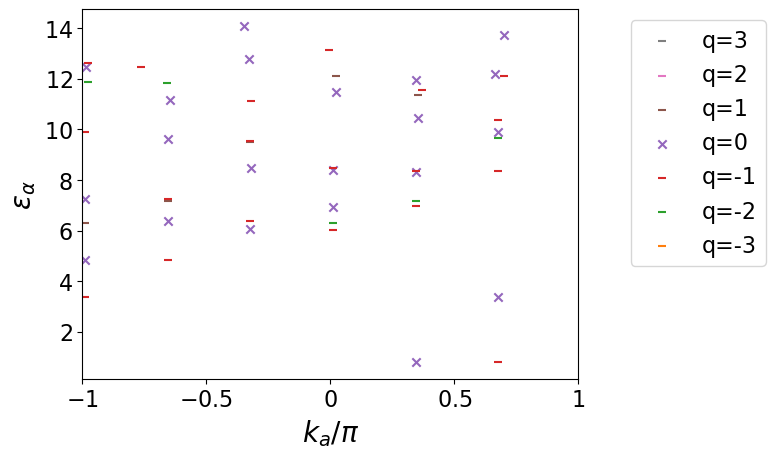

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
    
x = []
y = []
z = []    

for row in data2['mr_ent_spectrum']:
    x.append(float(row[0]))
    y.append(float(row[1]))
    z.append(int(row[2]))

for value in np.linspace(3, -3, 7, dtype=int):
    xvalue = []
    yvalue = []
    for i in range(len(x)):
        if z[i] == value:
            xvalue.append(x[i])
            yvalue.append(y[i])
    if value != 0:
        ax.scatter(xvalue, yvalue, marker='_', c='C{}'.format((value + 4) % 10), label='q={}'.format(value))
    else:
        ax.scatter(xvalue, yvalue, marker='x', c='C{}'.format((value + 4) % 10), label='q={}'.format(value))

ax.set_xlabel(r"$k_a / \pi$", fontsize=20)
ax.set_ylabel(r"$\epsilon_\alpha$", fontsize=20)
ax.set_xlim(-1, 1)
#ax.set_ylim(0., 10.)
ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
plt.xticks(np.arange(-1, 1.1, 0.5))
plt.show()

# Try with t_3 ≠ 0

# Bosonic

In [2]:
import numpy as np
import random

from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import BosonSite, FermionSite
from tenpy.models.lattice import Square

import logging
logging.basicConfig(level=logging.INFO)

#M: Added ent_spectrum
data1 = dict(phi_ext=np.linspace(0, 2.0, 21), QL=[], ent_spectrum=[], mr_ent_spectrum=[])

model_params = dict(Lx=4, Ly=4, filling=(1, 8), nphi=(1, 4), mod = 'BosHof',
                    Jx=1, Jy=1, mu=0, U=0, Nmax=1,
                    bc_MPS='infinite', bc_x='periodic', bc_y='periodic',
                    conserve='N', order='default', gauge='landau_x', t3 = -0.25)

dmrg_params = {
    'mixer': True,  # setting this to True helps to escape local minima
    'mixer_params': {
        'amplitude': 1.e-5,
        'decay': 1.2,
        'disable_after': 30
    },
    'trunc_params': {
        'chi_max': 50,
        'svd_min': 1.e-10,
    },
    'max_E_err': 1.e-8,
    'max_S_err': 1.e-6,-90k 
    'max_sweeps': 150,
    'verbose': 1,
    'combine': True
}

L = model_params['Lx'] * model_params['Ly']
fill = model_params['filling'][0] / model_params['filling'][1]
prod_state = np.zeros(L, dtype=int)
prod_state[random.sample(range(L), int(fill*L))] = 1
print(prod_state)

eng = None
QLs = []
for phi in np.linspace(0, 2.0, 21):

    model_params['phi'] = phi
    M = ZeroQuadraticModel(model_params)

    if eng is None:  # first time in the loop
        psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    else:
        dmrg_params['mixer'] = False
        eng.init_env(model=M)  # re-initialize
    E, psi = eng.run()
    QL = psi.average_charge(bond=0)[0]
    data1['QL'].append(QL)
    data1['ent_spectrum'].append(psi.entanglement_spectrum(by_charge=True)[0])

    
    

psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
E, psi = eng.run()

(Un, W, q, ov, trunc_err) = psi.compute_K(perm=M.lat, trunc_par={'chi_max': 400}, canonicalize=1.e-6, verbose=0)

for i in range(len(W)):
    qval=q.to_qflat()[i][0] 
    K=np.angle(W[i])/np.pi 
    epsilon=-np.log(np.abs(W[i]))
    data1['mr_ent_spectrum'].append([K, epsilon, qval])

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQuadraticModel
Reading 'bc_MPS'='infinite' for config ZeroQuadraticModel
Reading 'bc_x'='periodic' for config ZeroQuadraticModel
Reading 'bc_y'='periodic' for config ZeroQuadraticModel
Reading 'conserve'='N' for config ZeroQuadraticModel
Reading 'Nmax'=1 for config ZeroQuadraticModel
Reading 't3'=-0.25 for config ZeroQuadraticModel
Reading 'nphi'=(1, 4) for config ZeroQuadraticModel
Reading 'phi'=0.0 for config ZeroQuadraticModel
Reading 'mu'=0 for config ZeroQuadraticModel
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Updating environment
.
Reading 'max_sweeps'=150 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEng

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff
/Users/mathiraja/TeNPy/tenpy/algorithms/dmrg.py:1997: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Updating environment
.....
sweep 10, age = 528
Energy = -0.3052585159323193, S = nan, norm_err = 1.1e-06
Current memory usage 145872.0 MB, time elapsed: 13.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5922e-06, max_E_trunc = 4.1465e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 1008
Energy = -0.3052612017438694, S = nan, norm_err = 5.0e-07
Current memory usage 147552.0 MB, time elapsed: 21.2 s
Delta E = -2.6858e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8434e-07, max_E_trunc = 2.4310e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 1488
Energy = -0.3052622940566412, S = 0.7917600634826888, norm_err = 2.0e-11
Current memory usage 155520.0 MB, time elapsed: 27.5 s
Delta E = -1.0923e-07, Delta S = nan (per sweep)
max_trunc_err = 

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff


Updating environment
.....
sweep 10, age = 2480
Energy = -0.3068182690903889, S = 0.7846677966378452, norm_err = 2.1e-11
Current memory usage 160976.0 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.1105e-07, max_E_trunc = 1.7473e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 2960
Energy = -0.3068182695540678, S = 0.7846672481669390, norm_err = 1.9e-11
Current memory usage 161296.0 MB, time elapsed: 7.8 s
Delta E = -4.6368e-11, Delta S = -5.4847e-08 (per sweep)
max_trunc_err = 3.1099e-07, max_E_trunc = 1.7469e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 2960, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQ

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 3472
Energy = -0.3107415446619655, S = 0.7670331378638022, norm_err = 1.5e-12
Current memory usage 161424.0 MB, time elapsed: 4.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.8270e-07, max_E_trunc = 1.1854e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 3952
Energy = -0.3107415416730746, S = 0.7670394368247567, norm_err = 2.0e-12
Current memory usage 161472.0 MB, time elapsed: 7.2 s
Delta E = 2.9889e-10, Delta S = 6.2990e-07 (per sweep)
max_trunc_err = 1.8599e-07, max_E_trunc = 1.2053e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 3952, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQua

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 4464
Energy = -0.3153196416423327, S = 0.7472169749588928, norm_err = 2.0e-12
Current memory usage 161840.0 MB, time elapsed: 4.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.5923e-07, max_E_trunc = 9.4855e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 4944
Energy = -0.3153196474110871, S = 0.7472265401164553, norm_err = 2.4e-12
Current memory usage 161872.0 MB, time elapsed: 8.3 s
Delta E = -5.7688e-10, Delta S = 9.5652e-07 (per sweep)
max_trunc_err = 1.6895e-07, max_E_trunc = 9.9737e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 4944, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQu

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 5456
Energy = -0.3188279304201629, S = 0.7327983592110379, norm_err = 1.0e-12
Current memory usage 161904.0 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.1846e-07, max_E_trunc = 7.4293e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 5936
Energy = -0.3188279297262397, S = 0.7327997832938016, norm_err = 1.1e-12
Current memory usage 162016.0 MB, time elapsed: 6.7 s
Delta E = 6.9392e-11, Delta S = 1.4241e-07 (per sweep)
max_trunc_err = 1.2190e-07, max_E_trunc = 7.5916e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 5936, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQua

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 6448
Energy = -0.3201256819018496, S = 0.7276376939090570, norm_err = 1.7e-12
Current memory usage 162416.0 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.1690e-07, max_E_trunc = 7.4410e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 6928
Energy = -0.3201256816153375, S = 0.7276383074579634, norm_err = 1.7e-12
Current memory usage 162416.0 MB, time elapsed: 6.7 s
Delta E = 2.8651e-11, Delta S = 6.1355e-08 (per sweep)
max_trunc_err = 1.1692e-07, max_E_trunc = 7.4428e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 6928, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQua

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 7440
Energy = -0.3188279444990911, S = 0.7328088325592884, norm_err = 2.3e-12
Current memory usage 162480.0 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.1367e-07, max_E_trunc = 7.3493e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 7920
Energy = -0.3188279442923090, S = 0.7328089038230823, norm_err = 2.3e-12
Current memory usage 162480.0 MB, time elapsed: 6.7 s
Delta E = 2.0678e-11, Delta S = 7.1264e-09 (per sweep)
max_trunc_err = 1.1491e-07, max_E_trunc = 7.3334e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 7920, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQua

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 8432
Energy = -0.3153196861006364, S = 0.7472725277184931, norm_err = 2.9e-12
Current memory usage 162512.0 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.4248e-07, max_E_trunc = 9.0368e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 8912
Energy = -0.3153196872321899, S = 0.7472713440760149, norm_err = 2.9e-12
Current memory usage 163072.0 MB, time elapsed: 6.9 s
Delta E = -1.1316e-10, Delta S = -1.1836e-07 (per sweep)
max_trunc_err = 1.4224e-07, max_E_trunc = 9.0167e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 8912, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQ

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 9424
Energy = -0.3107415041537251, S = 0.7670470182966116, norm_err = 3.0e-12
Current memory usage 163088.0 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 2.0841e-07, max_E_trunc = 1.2923e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 9904
Energy = -0.3107415060116523, S = 0.7670427468615780, norm_err = 2.6e-12
Current memory usage 163504.0 MB, time elapsed: 7.1 s
Delta E = -1.8579e-10, Delta S = -4.2714e-07 (per sweep)
max_trunc_err = 2.0787e-07, max_E_trunc = 1.2904e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 9904, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQ

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
..

/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff


...
sweep 10, age = 10416
Energy = -0.3068182941583331, S = 0.7846881938752237, norm_err = 5.2e-12
Current memory usage 163504.0 MB, time elapsed: 5.4 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 2.6053e-07, max_E_trunc = 1.5019e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 10896
Energy = -0.3068182944351605, S = 0.7846872168859461, norm_err = 7.1e-12
Current memory usage 163536.0 MB, time elapsed: 9.6 s
Delta E = -2.7683e-11, Delta S = -9.7699e-08 (per sweep)
max_trunc_err = 2.6101e-07, max_E_trunc = 1.4912e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 10896, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQuadraticModel
Readin

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 11408
Energy = -0.3052623210692644, S = 0.7917575953567033, norm_err = 5.6e-12
Current memory usage 163728.0 MB, time elapsed: 4.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.1016e-07, max_E_trunc = 1.9403e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 11888
Energy = -0.3052623245729080, S = 0.7917528045871813, norm_err = 2.6e-12
Current memory usage 163728.0 MB, time elapsed: 8.4 s
Delta E = -3.5036e-10, Delta S = -4.7908e-07 (per sweep)
max_trunc_err = 3.0685e-07, max_E_trunc = 1.9288e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 11888, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Ze

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 12400
Energy = -0.3068182488023012, S = 0.7846448110516866, norm_err = 1.5e-11
Current memory usage 163744.0 MB, time elapsed: 5.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.1294e-07, max_E_trunc = 1.7594e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 12880
Energy = -0.3068182489225535, S = 0.7846444213832298, norm_err = 1.4e-11
Current memory usage 163760.0 MB, time elapsed: 8.7 s
Delta E = -1.2025e-11, Delta S = -3.8967e-08 (per sweep)
max_trunc_err = 3.1323e-07, max_E_trunc = 1.7601e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 12880, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Ze

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 13392
Energy = -0.3107415455891669, S = 0.7670308830685511, norm_err = 5.1e-12
Current memory usage 163824.0 MB, time elapsed: 4.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.8179e-07, max_E_trunc = 1.1837e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 13872
Energy = -0.3107415423058626, S = 0.7670360072115003, norm_err = 7.0e-12
Current memory usage 164336.0 MB, time elapsed: 7.4 s
Delta E = 3.2833e-10, Delta S = 5.1241e-07 (per sweep)
max_trunc_err = 1.8421e-07, max_E_trunc = 1.1979e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 13872, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Zero

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 14384
Energy = -0.3153196625153214, S = 0.7472461621759338, norm_err = 1.5e-12
Current memory usage 164480.0 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.6248e-07, max_E_trunc = 1.0045e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 14864
Energy = -0.3153196622375560, S = 0.7472467720619355, norm_err = 1.6e-12
Current memory usage 164496.0 MB, time elapsed: 7.2 s
Delta E = 2.7777e-11, Delta S = 6.0989e-08 (per sweep)
max_trunc_err = 1.6254e-07, max_E_trunc = 1.0047e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 14864, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Zero

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 15376
Energy = -0.3188279202298645, S = 0.7327937318794824, norm_err = 9.5e-13
Current memory usage 164512.0 MB, time elapsed: 4.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.2084e-07, max_E_trunc = 7.5489e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 15856
Energy = -0.3188279190311221, S = 0.7327962666300880, norm_err = 1.1e-12
Current memory usage 164592.0 MB, time elapsed: 7.3 s
Delta E = 1.1987e-10, Delta S = 2.5348e-07 (per sweep)
max_trunc_err = 1.2344e-07, max_E_trunc = 7.6994e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 15856, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Zero

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 16368
Energy = -0.3201256822260348, S = 0.7276345543266837, norm_err = 9.3e-13
Current memory usage 164592.0 MB, time elapsed: 4.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.1289e-07, max_E_trunc = 7.0923e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 16848
Energy = -0.3201256820366609, S = 0.7276351912600254, norm_err = 9.3e-13
Current memory usage 164608.0 MB, time elapsed: 7.1 s
Delta E = 1.8937e-11, Delta S = 6.3693e-08 (per sweep)
max_trunc_err = 1.1227e-07, max_E_trunc = 7.0049e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 16848, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Ze

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff


Updating environment
.....
sweep 10, age = 17360
Energy = -0.3188279534560934, S = 0.7328100427844193, norm_err = 1.2e-12
Current memory usage 164640.0 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.1597e-07, max_E_trunc = 7.5121e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 17840
Energy = -0.3188279538706240, S = 0.7328088465208288, norm_err = 1.2e-12
Current memory usage 164720.0 MB, time elapsed: 6.8 s
Delta E = -4.1453e-11, Delta S = -1.1963e-07 (per sweep)
max_trunc_err = 1.1480e-07, max_E_trunc = 7.4406e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 17840, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Ze

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 18352
Energy = -0.3153196784267607, S = 0.7472684623332730, norm_err = 1.5e-12
Current memory usage 164736.0 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.4712e-07, max_E_trunc = 9.0044e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 18832
Energy = -0.3153196791805897, S = 0.7472667711040217, norm_err = 1.3e-12
Current memory usage 164752.0 MB, time elapsed: 7.0 s
Delta E = -7.5383e-11, Delta S = -1.6912e-07 (per sweep)
max_trunc_err = 1.4691e-07, max_E_trunc = 8.9965e-07
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 18832, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Ze

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 19344
Energy = -0.3107415001710763, S = 0.7670425914538326, norm_err = 2.5e-12
Current memory usage 164768.0 MB, time elapsed: 4.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 2.0490e-07, max_E_trunc = 1.2366e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 19824
Energy = -0.3107415019750590, S = 0.7670393295953271, norm_err = 2.4e-12
Current memory usage 164768.0 MB, time elapsed: 7.3 s
Delta E = -1.8040e-10, Delta S = -3.2619e-07 (per sweep)
max_trunc_err = 2.0457e-07, max_E_trunc = 1.2372e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 19824, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Ze

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff


Updating environment
.....
sweep 10, age = 20336
Energy = -0.3068182937125528, S = 0.7846887396845751, norm_err = 4.8e-12
Current memory usage 165088.0 MB, time elapsed: 6.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 2.6081e-07, max_E_trunc = 1.5025e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 20816
Energy = -0.3068182953576866, S = 0.7846861775621103, norm_err = 2.7e-12
Current memory usage 165120.0 MB, time elapsed: 10.7 s
Delta E = -1.6451e-10, Delta S = -2.5621e-07 (per sweep)
max_trunc_err = 2.6101e-07, max_E_trunc = 1.4912e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 20816, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='BosHof' for config ZeroQuadraticModel
Reading 'L'=(4, 4) for config ZeroQuadraticModel
Reading 'order'='default' for config Z

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 21328
Energy = -0.3052623184738650, S = 0.7917596046465479, norm_err = 1.1e-11
Current memory usage 165216.0 MB, time elapsed: 4.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.0040e-07, max_E_trunc = 1.8928e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 21808
Energy = -0.3052623196485911, S = 0.7917580581779108, norm_err = 6.8e-12
Current memory usage 165216.0 MB, time elapsed: 8.2 s
Delta E = -1.1747e-10, Delta S = -1.5465e-07 (per sweep)
max_trunc_err = 2.9921e-07, max_E_trunc = 1.8818e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 21808, maximum chi = 50
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<12 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<6 options>, 'trunc_param

/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff
/Users/mathiraja/TeNPy/tenpy/algorithms/dmrg.py:1997: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Updating environment
.....
sweep 10, age = 528
Energy = -0.3052623193257462, S = 0.7917501034474256, norm_err = 2.5e-11
Current memory usage 165536.0 MB, time elapsed: 4.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.1118e-07, max_E_trunc = 1.9468e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 1008
Energy = -0.3052623251715172, S = 0.7917586057276744, norm_err = 6.1e-12
Current memory usage 165536.0 MB, time elapsed: 8.2 s
Delta E = -5.8458e-10, Delta S = 8.5023e-07 (per sweep)
max_trunc_err = 3.0963e-07, max_E_trunc = 1.9393e-06
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 1008, maximum chi = 50


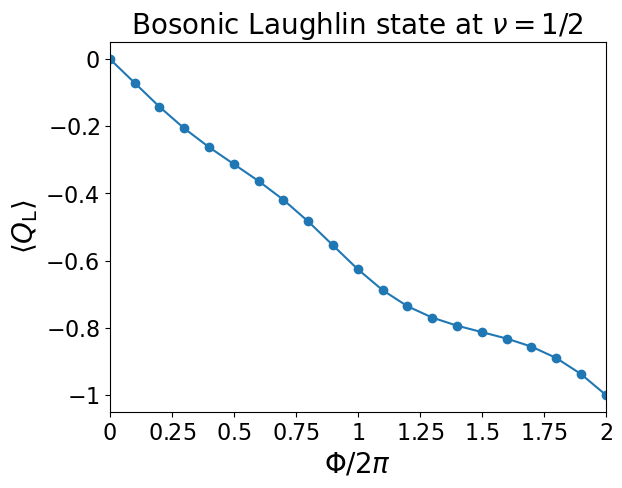

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data1['phi_ext'], data1['QL']-data1['QL'][0], marker='o')
ax.set_xlabel(r"$\Phi / 2 \pi$", fontsize=20)
ax.set_ylabel(r"$ \langle Q_\mathrm{L} \rangle $", fontsize=20)
ax.set_title(r"Bosonic Laughlin state at $\nu=1/2$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([0, 2])
plt.savefig('Bosonic_nu=1-2_charge_pumping', dpi = 1000)
plt.show()

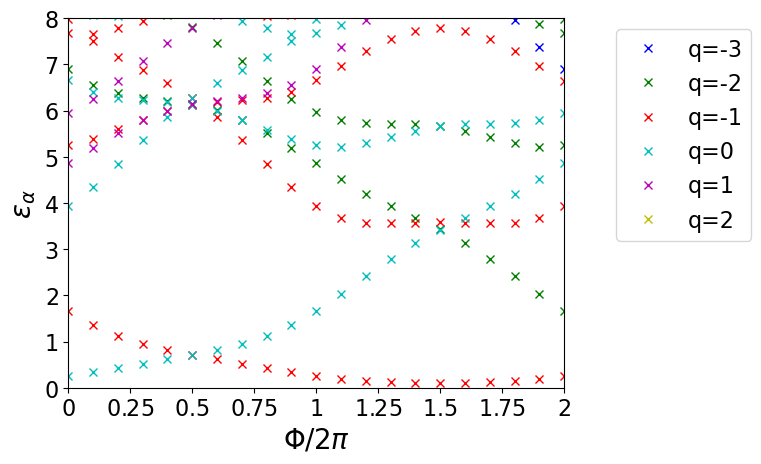

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_by_charge = {}
for phi_ext, spectrum in zip(data1['phi_ext'], data1['ent_spectrum']):
    for q, s in spectrum:
        if q > -4:
            q = q[0]
            label = ""
            if q not in color_by_charge:
                label = "q={q:d}".format(q=q)
                color_by_charge[q] = colors[len(color_by_charge) % len(colors)]
            color = color_by_charge[q]
            ax.plot(phi_ext*np.ones(s.shape), s,
                    linestyle='', marker='x', color=color, label=label)
ax.set_xlabel(r"$\Phi / 2 \pi$", fontsize=20)
ax.set_ylabel(r"$ \epsilon_\alpha $", fontsize=20)
ax.set_ylim(0., 8.)
ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([0, 2])
plt.savefig('Bosonic_nu=1-2_ent_spectrum.png', dpi = 1000)
plt.show()

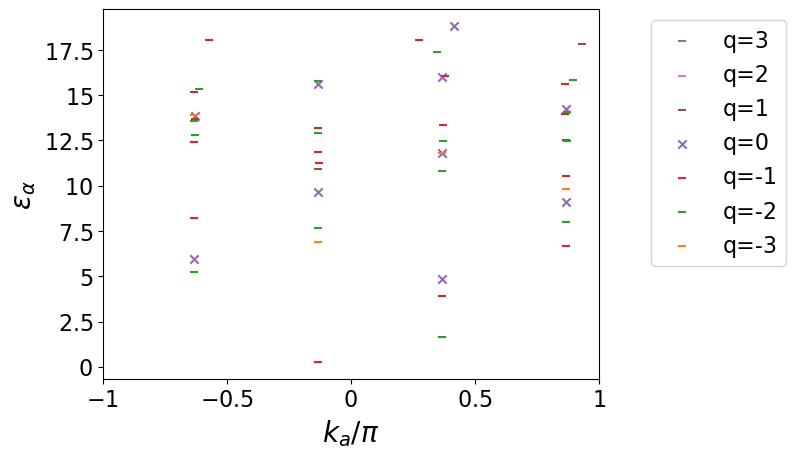

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
    
x = []
y = []
z = []    

for row in data1['mr_ent_spectrum']:
    x.append(float(row[0]))
    y.append(float(row[1]))
    z.append(int(row[2]))

for value in np.linspace(3, -3, 7, dtype=int):
    xvalue = []
    yvalue = []
    for i in range(len(x)):
        if z[i] == value:
            xvalue.append(x[i])
            yvalue.append(y[i])
    if value != 0:
        ax.scatter(xvalue, yvalue, marker='_', c='C{}'.format((value + 4) % 10), label='q={}'.format(value))
    else:
        ax.scatter(xvalue, yvalue, marker='x', c='C{}'.format((value + 4) % 10), label='q={}'.format(value))

ax.set_xlabel(r"$k_a / \pi$", fontsize=20)
ax.set_ylabel(r"$\epsilon_\alpha$", fontsize=20)
ax.set_xlim(-1, 1)
#ax.set_ylim(0., 10.)
ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
plt.xticks(np.arange(-1, 1.1, 0.5))
plt.show()

# Fermionic

In [6]:
import numpy as np
import random

from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import BosonSite, FermionSite
from tenpy.models.lattice import Square

import logging
logging.basicConfig(level=logging.INFO)

#M: Added ent_spectrum
data2 = dict(phi_ext=np.linspace(0, 3.0, 21), QL=[], ent_spectrum=[], mr_ent_spectrum=[])

#M: Did not change anything after this except the very last line
model_params = dict(Lx=3, Ly=6, filling=(1, 9), nphi=(1, 3), mod = 'HosFerm',
                    Jx=1, Jy=1, mu=0, v=10, mx=3, my=1,
                    bc_MPS='infinite', bc_x='periodic', bc_y='periodic',
                    conserve='N', order='default', gauge='landau_x', t3 = -0.25)


dmrg_params = {
    'mixer': True,  # setting this to True helps to escape local minima
    'mixer_params': {
        'amplitude': 1.e-5,
        'decay': 1.2,
        'disable_after': 30
    },
    'trunc_params': {
        'svd_min': 1.e-10,
    },
    'max_E_err': 1.e-8,
    'max_S_err': 1.e-6,
    'max_sweeps': 150,
    'verbose': 1,
    'combine': True
}

L = model_params['Lx'] * model_params['Ly']
fill = model_params['filling'][0] / model_params['filling'][1]
prod_state = np.zeros(L, dtype=int)
prod_state[random.sample(range(L), int(fill*L))] = 1
print(prod_state)
print(L)
print(len(prod_state))

eng = None
QLs = []
for phi in np.linspace(0, 3.0, 21):

    model_params['phi'] = phi
    M = ZeroQuadraticModel(model_params)

    if eng is None:  # first time in the loop
        psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    else:
        dmrg_params['mixer'] = False
        eng.init_env(model=M)  # re-initialize
    E, psi = eng.run()
    QL = psi.average_charge(bond=0)[0]
    data2['QL'].append(QL)
    data2['ent_spectrum'].append(psi.entanglement_spectrum(by_charge=True)[0])
    
    
    
    
psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
E, psi = eng.run()

(Un, W, q, ov, trunc_err) = psi.compute_K(perm=M.lat, trunc_par={'chi_max': 400}, canonicalize=1.e-6, verbose=0)

for i in range(len(W)):
    qval=q.to_qflat()[i][0] 
    K=np.angle(W[i])/np.pi 
    epsilon=-np.log(np.abs(W[i]))
    data2['mr_ent_spectrum'].append([K, epsilon, qval])

[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
18
18
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQuadraticModel
Reading 'bc_MPS'='infinite' for config ZeroQuadraticModel
Reading 'bc_x'='periodic' for config ZeroQuadraticModel
Reading 'bc_y'='periodic' for config ZeroQuadraticModel
Reading 'conserve'='N' for config ZeroQuadraticModel
Reading 't3'=-0.25 for config ZeroQuadraticModel
Reading 'nphi'=(1, 3) for config ZeroQuadraticModel
Reading 'phi'=0.0 for config ZeroQuadraticModel
Reading 'mu'=0 for config ZeroQuadraticModel
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Updating environment


/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused option ['mixer_params'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'U', 'filling', 'gauge']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.


/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff
/Users/mathiraja/TeNPy/tenpy/algorithms/dmrg.py:1997: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Reading 'max_sweeps'=150 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 594
Energy = -0.2480580870372471, S = nan, norm_err = 1.0e-05
Current memory usage 594848.0 MB, time elapsed: 212.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1835e-05, max_E_trunc = 4.8399e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 1134
Energy = -0.2480900887053521, S = nan, norm_err = 2.9e-06
Current memory usage 598608.0 MB, time elapsed: 257.6 s
Delta E = -3.2002e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2696e-06, max_E_trunc = 3.4388e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.


/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff


Updating environment
.....
sweep 10, age = 2790
Energy = -0.2480571403670303, S = 1.2413918242151951, norm_err = 1.0e-08
Current memory usage 605312.0 MB, time elapsed: 68.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.7820e-06, max_E_trunc = 3.6005e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 3330
Energy = -0.2480572040119190, S = 1.2414124485494362, norm_err = 9.5e-09
Current memory usage 605344.0 MB, time elapsed: 114.7 s
Delta E = -6.3645e-09, Delta S = 2.0624e-06 (per sweep)
max_trunc_err = 3.7400e-06, max_E_trunc = 3.5825e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 3870
Energy = -0.2480572048046794, S = 1.2414076010676760, norm_err = 9.4e-09
Current memory usage 605376.0 MB, time elapsed: 164.8 s
Delta E = -7.9276e-11, Delta S = -4.8475e-07 (per sweep)
max_trunc_err = 3.7421

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 4446
Energy = -0.2479754601798921, S = 1.2381796685514168, norm_err = 1.3e-08
Current memory usage 605616.0 MB, time elapsed: 76.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.5960e-06, max_E_trunc = 3.3165e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 4986
Energy = -0.2479754726259797, S = 1.2381693039958124, norm_err = 1.3e-08
Current memory usage 605616.0 MB, time elapsed: 118.9 s
Delta E = -1.2446e-09, Delta S = -1.0365e-06 (per sweep)
max_trunc_err = 3.6148e-06, max_E_trunc = 3.3265e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 5526
Energy = -0.2479754721320799, S = 1.2381661961066119, norm_err = 1.3e-08
Current memory usage 606512.0 MB, time elapsed: 161.5 s
Delta E = 4.9390e-11, Delta S = -3.1079e-07 (per sweep)
max_trunc_err = 3.62

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 6102
Energy = -0.2479173456533456, S = 1.2358325676621844, norm_err = 4.7e-09
Current memory usage 606512.0 MB, time elapsed: 57.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.6476e-06, max_E_trunc = 3.3641e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 6642
Energy = -0.2479173481546708, S = 1.2358590458233010, norm_err = 5.7e-09
Current memory usage 606512.0 MB, time elapsed: 126.6 s
Delta E = -2.5013e-10, Delta S = 2.6478e-06 (per sweep)
max_trunc_err = 3.6348e-06, max_E_trunc = 3.3474e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 7182
Energy = -0.2479173388055263, S = 1.2358662312550210, norm_err = 5.8e-09
Current memory usage 606512.0 MB, time elapsed: 176.4 s
Delta E = 9.3491e-10, Delta S = 7.1854e-07 (per sweep)
max_trunc_err = 3.6321

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 7758
Energy = -0.2479298305726161, S = 1.2364297774182105, norm_err = 4.2e-09
Current memory usage 606512.0 MB, time elapsed: 69.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.7135e-06, max_E_trunc = 3.3443e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 8298
Energy = -0.2479298448051597, S = 1.2364266254445071, norm_err = 4.1e-09
Current memory usage 606512.0 MB, time elapsed: 109.8 s
Delta E = -1.4233e-09, Delta S = -3.1520e-07 (per sweep)
max_trunc_err = 3.6873e-06, max_E_trunc = 3.3212e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 8298, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(3, 6) for config ZeroQuadraticModel
Reading 'order'='def

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 8874
Energy = -0.2480035143491680, S = 1.2392411990550369, norm_err = 2.0e-09
Current memory usage 606512.0 MB, time elapsed: 66.4 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.7120e-06, max_E_trunc = 3.6953e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 9414
Energy = -0.2480035191395271, S = 1.2392484307315137, norm_err = 1.7e-09
Current memory usage 606512.0 MB, time elapsed: 106.7 s
Delta E = -4.7904e-10, Delta S = 7.2317e-07 (per sweep)
max_trunc_err = 3.7168e-06, max_E_trunc = 3.6995e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 9414, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(3, 6) for config ZeroQuadraticModel
Reading 'order'='defa

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 9990
Energy = -0.2480769761449185, S = 1.2419377212939691, norm_err = 2.7e-09
Current memory usage 606720.0 MB, time elapsed: 64.3 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.9935e-06, max_E_trunc = 4.0301e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 10530
Energy = -0.2480769369472000, S = 1.2419645680290139, norm_err = 1.8e-09
Current memory usage 606720.0 MB, time elapsed: 106.1 s
Delta E = 3.9198e-09, Delta S = 2.6847e-06 (per sweep)
max_trunc_err = 4.0037e-06, max_E_trunc = 4.0257e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 11070
Energy = -0.2480769280158357, S = 1.2419818358944381, norm_err = 1.7e-09
Current memory usage 606736.0 MB, time elapsed: 148.4 s
Delta E = 8.9314e-10, Delta S = 1.7268e-06 (per sweep)
max_trunc_err = 4.012

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 12726
Energy = -0.2480891092470251, S = 1.2423865172188726, norm_err = 1.0e-08
Current memory usage 606736.0 MB, time elapsed: 65.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.3929e-06, max_E_trunc = 3.7168e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 13266
Energy = -0.2480891385119245, S = 1.2423975466753854, norm_err = 9.7e-09
Current memory usage 606736.0 MB, time elapsed: 113.1 s
Delta E = -2.9265e-09, Delta S = 1.1029e-06 (per sweep)
max_trunc_err = 3.3935e-06, max_E_trunc = 3.7158e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 13806
Energy = -0.2480891320277073, S = 1.2424020160970544, norm_err = 1.0e-08
Current memory usage 606736.0 MB, time elapsed: 159.1 s
Delta E = 6.4842e-10, Delta S = 4.4694e-07 (per sweep)
max_trunc_err = 3.3

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 14382
Energy = -0.2480299063533569, S = 1.2400768117845518, norm_err = 9.8e-09
Current memory usage 606736.0 MB, time elapsed: 69.4 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.7020e-06, max_E_trunc = 3.2739e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 14922
Energy = -0.2480299265421814, S = 1.2400887256250834, norm_err = 9.7e-09
Current memory usage 606736.0 MB, time elapsed: 113.3 s
Delta E = -2.0189e-09, Delta S = 1.1914e-06 (per sweep)
max_trunc_err = 3.7169e-06, max_E_trunc = 3.2688e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 15462
Energy = -0.2480299278798712, S = 1.2400904746553763, norm_err = 9.6e-09
Current memory usage 606736.0 MB, time elapsed: 159.4 s
Delta E = -1.3377e-10, Delta S = 1.7490e-07 (per sweep)
max_trunc_err = 3.

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 16038
Energy = -0.2479496694078181, S = 1.2371876581097847, norm_err = 8.7e-09
Current memory usage 606736.0 MB, time elapsed: 67.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.5881e-06, max_E_trunc = 3.3813e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 16578
Energy = -0.2479496980687499, S = 1.2371971694624850, norm_err = 8.6e-09
Current memory usage 606736.0 MB, time elapsed: 109.2 s
Delta E = -2.8661e-09, Delta S = 9.5114e-07 (per sweep)
max_trunc_err = 3.5573e-06, max_E_trunc = 3.3418e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 16578, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(3, 6) for config ZeroQuadraticModel
Reading 'order'='d

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 17154
Energy = -0.2479125370307934, S = 1.2359413223508440, norm_err = 3.8e-09
Current memory usage 606736.0 MB, time elapsed: 62.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.6318e-06, max_E_trunc = 3.1434e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 17694
Energy = -0.2479125400356629, S = 1.2359417372114176, norm_err = 3.8e-09
Current memory usage 606736.0 MB, time elapsed: 105.4 s
Delta E = -3.0049e-10, Delta S = 4.1486e-08 (per sweep)
max_trunc_err = 3.6267e-06, max_E_trunc = 3.1403e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 17694, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(3, 6) for config ZeroQuadraticModel
Reading 'order'='d

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 18270
Energy = -0.2479503640858588, S = 1.2375381926305129, norm_err = 1.2e-09
Current memory usage 606736.0 MB, time elapsed: 67.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.5800e-06, max_E_trunc = 3.3651e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 18810
Energy = -0.2479503744658965, S = 1.2375354413183419, norm_err = 1.3e-09
Current memory usage 606736.0 MB, time elapsed: 112.1 s
Delta E = -1.0380e-09, Delta S = -2.7513e-07 (per sweep)
max_trunc_err = 3.5563e-06, max_E_trunc = 3.3870e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 18810, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(3, 6) for config ZeroQuadraticModel
Reading 'order'='

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 19386
Energy = -0.2480315062344592, S = 1.2402905805892130, norm_err = 1.4e-09
Current memory usage 606736.0 MB, time elapsed: 64.2 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.8396e-06, max_E_trunc = 3.8640e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 19926
Energy = -0.2480315075565108, S = 1.2402965685689955, norm_err = 1.5e-09
Current memory usage 606736.0 MB, time elapsed: 108.4 s
Delta E = -1.3221e-10, Delta S = 5.9880e-07 (per sweep)
max_trunc_err = 3.8478e-06, max_E_trunc = 3.8712e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 19926, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(3, 6) for config ZeroQuadraticModel
Reading 'order'='d

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 20502
Energy = -0.2480892402776994, S = 1.2426382715055762, norm_err = 2.5e-09
Current memory usage 606736.0 MB, time elapsed: 68.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.9823e-06, max_E_trunc = 4.1936e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 21042
Energy = -0.2480892104192662, S = 1.2426513511940631, norm_err = 2.9e-09
Current memory usage 606736.0 MB, time elapsed: 113.6 s
Delta E = 2.9858e-09, Delta S = 1.3080e-06 (per sweep)
max_trunc_err = 3.9463e-06, max_E_trunc = 4.1660e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 21582
Energy = -0.2480891948863599, S = 1.2426599304223171, norm_err = 3.0e-09
Current memory usage 606736.0 MB, time elapsed: 159.7 s
Delta E = 1.5533e-09, Delta S = 8.5792e-07 (per sweep)
max_trunc_err = 3.93

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 22158
Energy = -0.2480759909934326, S = 1.2420565107399741, norm_err = 1.3e-08
Current memory usage 606736.0 MB, time elapsed: 68.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.6075e-06, max_E_trunc = 3.3426e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 22698
Energy = -0.2480760667838745, S = 1.2420925022439995, norm_err = 1.3e-08
Current memory usage 606736.0 MB, time elapsed: 113.6 s
Delta E = -7.5790e-09, Delta S = 3.5992e-06 (per sweep)
max_trunc_err = 3.5523e-06, max_E_trunc = 3.3501e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 23238
Energy = -0.2480761589946370, S = 1.2420639311905763, norm_err = 1.2e-08
Current memory usage 606736.0 MB, time elapsed: 160.6 s
Delta E = -9.2211e-09, Delta S = -2.8571e-06 (per sweep)
max_trunc_err = 3

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 24354
Energy = -0.2480020958128332, S = 1.2391710433574223, norm_err = 7.4e-09
Current memory usage 606736.0 MB, time elapsed: 68.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.5077e-06, max_E_trunc = 3.3700e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 24894
Energy = -0.2480021336648406, S = 1.2391690930059440, norm_err = 9.9e-09
Current memory usage 606752.0 MB, time elapsed: 114.4 s
Delta E = -3.7852e-09, Delta S = -1.9504e-07 (per sweep)
max_trunc_err = 3.4592e-06, max_E_trunc = 3.3725e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 24894, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(3, 6) for config ZeroQuadraticModel
Reading 'order'='

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 25470
Energy = -0.2479294245989523, S = 1.2363496073882518, norm_err = 5.4e-09
Current memory usage 606768.0 MB, time elapsed: 69.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.6947e-06, max_E_trunc = 3.3698e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 26010
Energy = -0.2479294416803997, S = 1.2363525155164174, norm_err = 5.8e-09
Current memory usage 606768.0 MB, time elapsed: 117.1 s
Delta E = -1.7081e-09, Delta S = 2.9081e-07 (per sweep)
max_trunc_err = 3.6993e-06, max_E_trunc = 3.3677e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 26010, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(3, 6) for config ZeroQuadraticModel
Reading 'order'='d

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 26586
Energy = -0.2479164920121093, S = 1.2360628963669791, norm_err = 5.1e-09
Current memory usage 606768.0 MB, time elapsed: 67.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 4.0619e-06, max_E_trunc = 3.4963e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 27126
Energy = -0.2479165087659112, S = 1.2360543773307269, norm_err = 5.0e-09
Current memory usage 606768.0 MB, time elapsed: 113.9 s
Delta E = -1.6754e-09, Delta S = -8.5190e-07 (per sweep)
max_trunc_err = 4.0492e-06, max_E_trunc = 3.4805e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
DMRG finished after 20 sweeps.
total size = 27126, maximum chi = 50
Reading 'explicit_plus_hc'=False for config ZeroQuadraticModel
Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(3, 6) for config ZeroQuadraticModel
Reading 'order'='

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.


/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff


Updating environment
.....
sweep 10, age = 27702
Energy = -0.2479755035025038, S = 1.2383274544326270, norm_err = 1.3e-09
Current memory usage 606784.0 MB, time elapsed: 67.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.5487e-06, max_E_trunc = 3.5094e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 28242
Energy = -0.2479756330114924, S = 1.2383314453114622, norm_err = 1.9e-09
Current memory usage 606784.0 MB, time elapsed: 114.2 s
Delta E = -1.2951e-08, Delta S = 3.9909e-07 (per sweep)
max_trunc_err = 3.5324e-06, max_E_trunc = 3.5173e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 28782
Energy = -0.2479756338870579, S = 1.2383316981775014, norm_err = 1.9e-09
Current memory usage 606784.0 MB, time elapsed: 161.0 s
Delta E = -8.7557e-11, Delta S = 2.5287e-08 (per sweep)
max_trunc_err = 3.53

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 29358
Energy = -0.2480570392033820, S = 1.2413046505233734, norm_err = 3.3e-09
Current memory usage 606800.0 MB, time elapsed: 70.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.7695e-06, max_E_trunc = 3.7792e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 29898
Energy = -0.2480570380712632, S = 1.2413236647368784, norm_err = 3.7e-09
Current memory usage 606800.0 MB, time elapsed: 115.8 s
Delta E = 1.1321e-10, Delta S = 1.9014e-06 (per sweep)
max_trunc_err = 3.7792e-06, max_E_trunc = 3.7873e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 30438
Energy = -0.2480570362778407, S = 1.2413246710857337, norm_err = 3.8e-09
Current memory usage 606816.0 MB, time elapsed: 161.4 s
Delta E = 1.7934e-10, Delta S = 1.0063e-07 (per sweep)
max_trunc_err = 3.77

/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Updating environment
.....
sweep 10, age = 31014
Energy = -0.2480943268841808, S = 1.2425765064367116, norm_err = 9.2e-09
Current memory usage 606816.0 MB, time elapsed: 71.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.4985e-06, max_E_trunc = 3.4133e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 31554
Energy = -0.2480943523971241, S = 1.2425625121947581, norm_err = 9.4e-09
Current memory usage 606816.0 MB, time elapsed: 117.2 s
Delta E = -2.5513e-09, Delta S = -1.3994e-06 (per sweep)
max_trunc_err = 3.4408e-06, max_E_trunc = 3.3814e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 32094
Energy = -0.2480943577794379, S = 1.2425643619925049, norm_err = 9.5e-09
Current memory usage 606832.0 MB, time elapsed: 161.4 s
Delta E = -5.3823e-10, Delta S = 1.8498e-07 (per sweep)
max_trunc_err = 3

/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff
/Users/mathiraja/TeNPy/tenpy/algorithms/dmrg.py:1997: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Updating environment
.....
sweep 10, age = 594
Energy = -0.2480936141919940, S = 1.2421416494391933, norm_err = 1.4e-09
Current memory usage 607568.0 MB, time elapsed: 58.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.6830e-06, max_E_trunc = 3.6879e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 20, age = 1134
Energy = -0.2480944473863423, S = 1.2426421045038252, norm_err = 6.2e-09
Current memory usage 607568.0 MB, time elapsed: 100.3 s
Delta E = -8.3319e-08, Delta S = 5.0046e-05 (per sweep)
max_trunc_err = 3.7142e-06, max_E_trunc = 3.7250e-05
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
.....
sweep 30, age = 1674
Energy = -0.2480944501123506, S = 1.2426528758841293, norm_err = 6.2e-09
Current memory usage 607568.0 MB, time elapsed: 143.7 s
Delta E = -2.7260e-10, Delta S = 1.0771e-06 (per sweep)
max_trunc_err = 3.6959e-

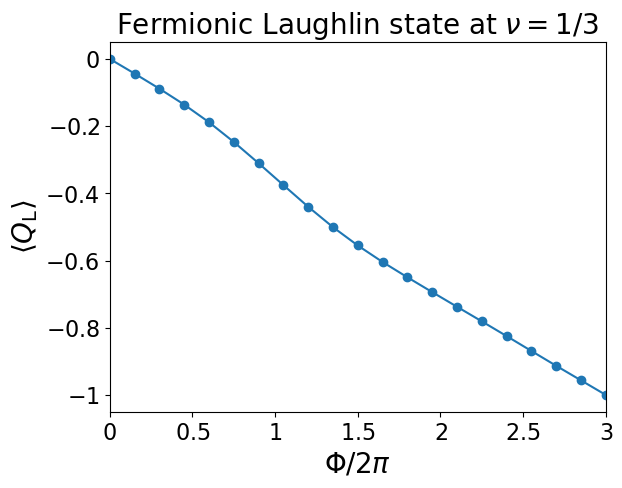

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data2['phi_ext'], data2['QL']-data2['QL'][0], marker='o')
ax.set_xlabel(r"$\Phi / 2 \pi$", fontsize=20)
ax.set_ylabel(r"$ \langle Q_\mathrm{L} \rangle $", fontsize=20)
ax.set_title(r"Fermionic Laughlin state at $\nu=1/3$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([0, 3])
plt.savefig('Fermionic_nu=1-3_charge_pumping.png', dpi = 1000)
plt.show()

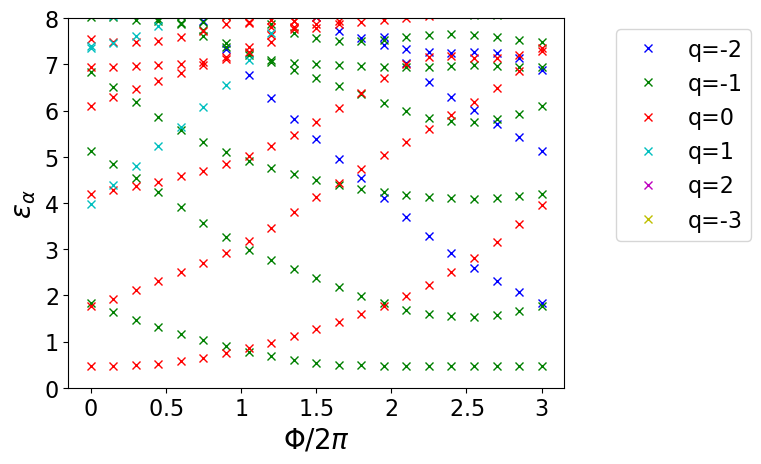

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_by_charge = {}
for phi_ext, spectrum in zip(data2['phi_ext'], data2['ent_spectrum']):
    for q, s in spectrum:
        if q > -4:
            q = q[0]
            label = ""
            if q not in color_by_charge:
                label = "q={q:d}".format(q=q)
                color_by_charge[q] = colors[len(color_by_charge) % len(colors)]
            color = color_by_charge[q]
            ax.plot(phi_ext*np.ones(s.shape), s,
                    linestyle='', marker='x', color=color, label=label)
ax.set_xlabel(r"$\Phi / 2 \pi$", fontsize=20)
ax.set_ylabel(r"$ \epsilon_\alpha $", fontsize=20)
ax.set_ylim(0., 8.)
ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
plt.savefig('Fermionic_nu=1-3_ent_spectrum.png', dpi = 1000)
#ax.set_xlim([0, 3])
plt.show()

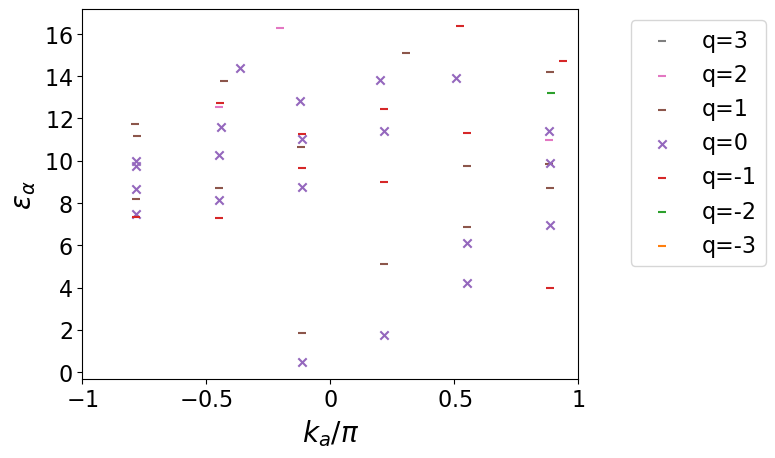

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
    
x = []
y = []
z = []    

for row in data2['mr_ent_spectrum']:
     x.append(float(row[0]))
    y.append(float(row[1]))
    z.append(int(row[2]))

for value in np.linspace(3, -3, 7, dtype=int):
    xvalue = []
    yvalue = []
    for i in range(len(x)):
        if z[i] == value:
            xvalue.append(x[i])
            yvalue.append(y[i])
    if value != 0:
        ax.scatter(xvalue, yvalue, marker='_', c='C{}'.format((value + 4) % 10), label='q={}'.format(value))
    else:
        ax.scatter(xvalue, yvalue, marker='x', c='C{}'.format((value + 4) % 10), label='q={}'.format(value))

ax.set_xlabel(r"$k_a / \pi$", fontsize=20)
ax.set_ylabel(r"$\epsilon_\alpha$", fontsize=20)
ax.set_xlim(-1, 1)
#ax.set_ylim(0., 10.)
ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
plt.xticks(np.arange(-1, 1.1, 0.5))
plt.show()

In [5]:
model_params = dict(Lx=3, Ly=6, filling=(1, 9), nphi=(1, 3), mod = 'HosFerm',
                    Jx=1, Jy=1, mu=0, v=10, mx=3, my=1,
                    bc_MPS='infinite', bc_x='periodic', bc_y='periodic',
                    conserve='N', order='default', gauge='landau_x', t = 0, t3 = 0)


M = ZeroQuadraticModel(model_params)
print(max(M.H_MPO.chi))
hamiltonian = M.calc_H_MPO()
L = model_params['Lx'] * model_params['Ly']
fill = model_params['filling'][0] / model_params['filling'][1]
prod_state = np.zeros(L, dtype=int)
prod_state[random.sample(range(L), int(fill*L))] = 1
psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
print('corr_length is {}'.format(psi.correlation_length()))
print('ent entropy is {}'.format(psi.entanglement_entropy()[0]))
print('exp value is {}'.format(hamiltonian.expectation_value(psi)))


Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQuadraticModel
Reading 'bc_MPS'='infinite' for config ZeroQuadraticModel
Reading 'bc_x'='periodic' for config ZeroQuadraticModel
Reading 'bc_y'='periodic' for config ZeroQuadraticModel
Reading 'conserve'='N' for config ZeroQuadraticModel
Reading 't'=0 for config ZeroQuadraticModel
Reading 't3'=0 for config ZeroQuadraticModel
Reading 'nphi'=(1, 3) for config ZeroQuadraticModel
Reading 'mu'=0 for config ZeroQuadraticModel
8
corr_length is 0.0
ent entropy is -0.0
exp value is 0.0


/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/networks/mps.py:3697: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)
